# Create a dataset of worldwide cities
This notebook processes several open-source GIS datasets containing relevant information on cities: 
* basic information such as population, geographical region, country, etc.
* population density data from the LandScan project
* nighttime luminosity data from NASA's VIIRS mission
* building density data from the GUF project
* city boundaries from the Census Bureau (US), Urban Atlas/Eurostat (EU), and GDAM (World)

The goal is to create a curated list of _major_ cities world-wide to use in subsequent analysis and machine learning applications.

The approach we follow is:
* start from the GADM database of administrative boundaries for world cities. This data contains city, province, and country names/codes, as well as geometry (polygon) data of boundaries for about $46,000$ cities'
* use the LandScan data to extract the population for each city. This will give consistent (if perhaps inaccurate) estimates for population.
* retain just major cities (over 10,000 inhabitants) for analysis

Another route could have been to start with a list of cities and their population (e.g., the one available at [this link](https://www.maxmind.com/en/free-world-cities-database)). However, there are issues (mainly slight differences in city names, e.g., different spellings, accents, dashes, etc.) in integrating cities in that list with information from other databases, particularly the administrative boundaries. 

### Load packages

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads
from shapely.ops import cascaded_union

import sys, os, time
import glob
import copy

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

In [2]:
# path to save data

outPath = "/home/data/world-cities/"

if not os.path.exists(outPath):
	os.makedirs(outPath)

# Integrate GIS raster datasets

In [3]:
# satellite imagery modules
import pysatml
from pysatml import satimage as satimg

In [4]:
# client for SAR built geometry

bld_sarguf_path = "/home/data/GUF28/guf28_merged.tif"
sarFiles = glob.glob(bld_sarguf_path)
sarImgClient = satimg.SatImage(sarFiles)

(-65.00066738877278, -180.0003314054922, 85.00000094500146, 180.00111704000867)


In [5]:
# client for nightlights

luminosity_path = "/home/data/VIIRS/2015/viirs_merged.tif"
nliFiles = glob.glob(luminosity_path)
nliImgClient = satimg.SatImage(nliFiles)

(-64.99791778665006, -180.00208333335016, 75.00208333335007, 179.9979195466502)


In [6]:
# client for population density

population_path = "/home/data/landscan-population/LandScan2012/ArcGIS/Population/lspop2012/w001001x.adf"
popFiles = glob.glob(population_path)
popImgClient = satimg.SatImage(popFiles)

(-90.00000000000009, -180.00000000000017, 83.9999999999305, 179.9999999998562)


In [7]:
# client for water mask

watermask_path = "/home/data/world_water_areas/hydro.tif"
wtrFiles = glob.glob(watermask_path)
wtrImgClient = satimg.SatImage(wtrFiles)

(-65.00416610665006, -180.00416666665018, 75.00416666665006, 180.00416522665017)


# Process administrative boundary data

Boundaries for whole world are available from the [GADM database](http://www.gadm.org/version2).

In [8]:
boundaries_path = "/home/data/city-boundaries/GADM/world-levels/gadm28_adm2.shp"

gadm_gdf = gpd.read_file(boundaries_path)
gadm_gdf.dropna(subset=['TYPE_2', 'NAME_2'], inplace=True)

print gadm_gdf.shape

gadm_gdf.head()

(45608, 18)


,CCA_2,CCN_2,ENGTYPE_2,HASC_2,ID_0,ID_1,ID_2,ISO,NAME_0,NAME_1,NAME_2,NL_NAME_2,OBJECTID,Shape_Area,Shape_Leng,TYPE_2,VARNAME_2,geometry
0,None,0,District,AF.BD.BA,1,1,1,AFG,Afghanistan,Badakhshan,Baharak,None,1,0.304174,3.464540,Wuleswali,None,"POLYGON ((71.18168640136724 36.49195861816412,..."
1,None,0,District,AF.BD.DA,1,1,2,AFG,Afghanistan,Badakhshan,Darwaz,None,2,0.300430,2.980827,Wuleswali,None,"POLYGON ((71.33762359619141 38.11840820312511,..."
2,None,0,District,AF.BD.FA,1,1,3,AFG,Afghanistan,Badakhshan,Fayz abad,None,3,0.298038,2.395813,Wuleswali,None,"POLYGON ((70.09976196289062 37.00258255004883,..."
3,None,0,District,AF.BD.IK,1,1,4,AFG,Afghanistan,Badakhshan,Ishkashim,None,4,0.158482,2.534993,Wuleswali,None,"POLYGON ((71.3193359375 37.24847793579107, 71...."
4,None,0,District,AF.BD.JU,1,1,5,AFG,Afghanistan,Badakhshan,Jurm,None,5,0.353425,2.846146,Wuleswali,None,"POLYGON ((71.18168640136724 36.49195861816412,..."


#### Create processed dataset of cities and their boundaries

In [9]:
# some country/city names contain non-ASCII characters encoded as UTF-8

utf8_to_ascii = lambda x: u''.join([x]).encode('utf-8').strip().decode("utf-8").encode("ascii", "ignore")

import re
clean_string = lambda s: re.sub(r'[^a-zA-Z0-9 ]','', s)

# utility functions to compute sizes of polygons in km
from pysatml.utils.gis_utils import \
    compute_geo_distance_km, compute_polygon_area_km2, compute_polygon_size


In [10]:
cities_gdf = gadm_gdf[['NAME_0', 'ISO', 'NAME_1', 'NAME_2', 'geometry']].copy()
cities_gdf.rename(columns={"NAME_1":"province", 
                           "ISO":"countrycode",
                           "NAME_2":"city",
                           'NAME_0':"country"}, inplace=True)

cities_gdf['city'] = cities_gdf['city'].apply(lambda x: clean_string(utf8_to_ascii(x).lower()))
cities_gdf['province'] = cities_gdf['province'].apply(lambda x: clean_string(utf8_to_ascii(x).lower()))
cities_gdf['countrycode'] = cities_gdf['countrycode'].str.lower()
cities_gdf['country'] = cities_gdf['country'].apply(lambda x: clean_string(utf8_to_ascii(x).lower()))

# some cities/municipalities have the same name/province/country,
# we assume that they're part of the same region, and combine the boundary
# into a single polygon
cities_gdf = cities_gdf.groupby(['city', 'province', 'country', 'countrycode'])\
    .apply(lambda x: cascaded_union(x['geometry'].values) if len(x)>1 else x['geometry'].values[0]).reset_index()\
    .rename(columns={0:"geometry"})
cities_gdf = gpd.GeoDataFrame(cities_gdf) # the groupby operation casts to a Pandas DataFrame
    
# define a unique name for each city
cities_gdf['City'] = map(lambda city, province, country: "%s, %s, %s"%(city, province, country),
                        cities_gdf['city'], 
                        cities_gdf['province'], 
                        cities_gdf['countrycode'])

# compute basic area and scale stats for each city
cities_gdf['area'] = cities_gdf['geometry'].apply(lambda x: compute_polygon_area_km2(x))
cities_gdf['scale'] = cities_gdf['geometry'].apply(lambda p: max(compute_polygon_size(p)))
cities_gdf['location'] = cities_gdf['geometry'].apply(lambda x: x.centroid if x is not None else None)

In [11]:
# add in information on geographical regions

regions_df = pd.read_csv("/home/data/cities-info/countries_regions.csv")
country2region = {r:c for r,c in zip(regions_df['alpha-3'].str.lower(), regions_df['region'])}
country2subregion = {r:c for r,c in zip(regions_df['alpha-3'].str.lower(), regions_df['sub-region'])}

# manually add in Kosovo (apparently a country)
country2region['xko'] = 'Europe'
country2subregion['xko'] = 'Southern Europe'

cities_gdf['region'] = cities_gdf['countrycode'].apply(lambda x: country2region[x] if x in country2region else np.nan)
cities_gdf['subregion'] = cities_gdf['countrycode'].apply(lambda x: country2subregion[x] if x in country2subregion else np.nan)

#GADMs with scale>200km: 1553 / 45351


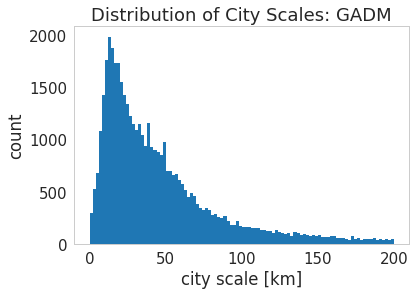

In [127]:
print "#GADMs with scale>200km: %d / %d" % (len(cities_gdf['scale'][cities_gdf['scale']>200]), len(cities_gdf['scale']))

sns.set_context("notebook", font_scale=1.5, rc={'axes.grid' : False})
cities_gdf['scale'][cities_gdf['scale']<200].hist(bins=100)
plt.xlabel("city scale [km]")
plt.ylabel("count")
plt.title("Distribution of City Scales: GADM")
plt.grid(False)

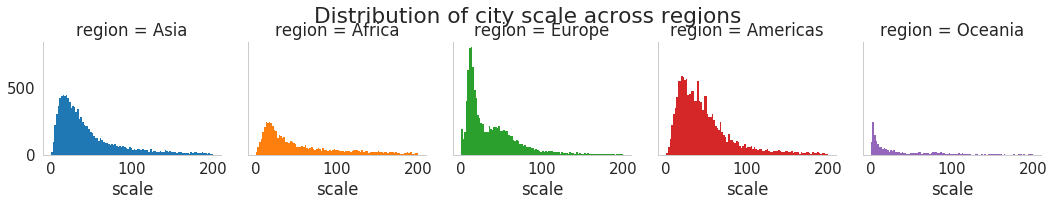

In [129]:
g = sns.FacetGrid(cities_gdf[cities_gdf['scale']<200], col="region", hue="region")
g = g.map(plt.hist, "scale", log=False, bins=100)
g.fig.suptitle("Distribution of city scale across regions\n\n")

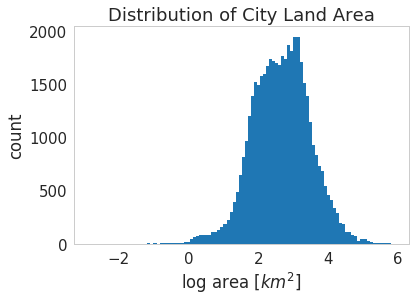

In [84]:
sns.set_context("notebook", font_scale=1.5, rc={'axes.grid' : False})

cities_gdf['area'].apply(np.log10).hist(bins=100)
plt.xlabel("log area [$km^2$]")
plt.ylabel("count")
plt.title("Distribution of City Land Area")
plt.grid(False)

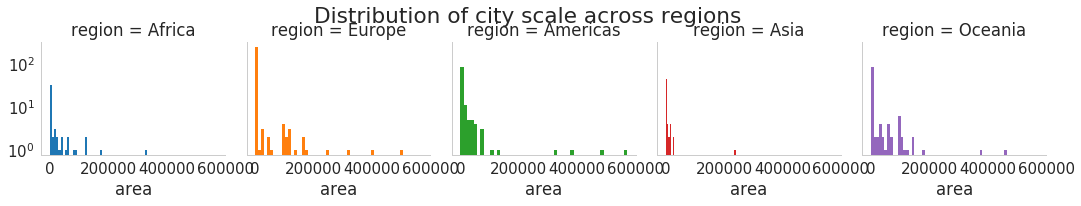

In [137]:
g = sns.FacetGrid(cities_gdf[cities_gdf['population']<500], col="region", hue="region")
g = g.map(plt.hist, "area", log=True, bins=50)
g.fig.suptitle("Distribution of city scale across regions\n\n")

#### Estimate population within city boundary for each city

In [14]:
city_population = []
for j,(i,r) in enumerate(cities_gdf.iterrows()):
    lonlat, boundary = r['location'].centroid.xy, r['geometry']
    cityname, countrycode = r['city'], r['countrycode']
    lon, lat = lonlat[0][0], lonlat[1][0]
    try:
        imgPOP = popImgClient.extract_polygon_mask(boundary, w=150)
    except:
        imgPOP = popImgClient.extract_polygon_mask(boundary.buffer(2).buffer(-2), w=50)
    imgPOP, bounds_mask = imgPOP[0], imgPOP[1]
    imgPOP[imgPOP<0] = 0
    city_pop = imgPOP[bounds_mask>0].sum()
    city_population += [city_pop]
    clear_output(wait=True)
    print "%s, %s (%d/%d): %d pop" % (cityname, countrycode, j, len(cities_gdf), city_pop)

city_population = pd.Series(city_population)
cities_gdf['population'] = city_population
cities_gdf = cities_gdf[cities_gdf['population']>0]

zyryanskiy rayon, rus (45466/45467): 12128 pop


In [15]:
print "There are %d/%d cities with more than 10k pop."%((cities_gdf['population']>10000).sum(), len(cities_gdf))

There are 32988/45351 cities with more than 10k pop.


In [16]:
# classify cities by population scale
# adapted after the new classification of Chinese cities
# http://english.gov.cn/policies/latest_releases/2014/11/25/content_281475015213546.htm

def f_classify_by_pop(d):
    if d < 100000:
        return "very-small"
    elif d < 200000:
        return "small-1"
    elif d < 500000:
        return "small-2"
    elif d < 1e6:
        return "medium"
    elif d < 5e6:
        return "large"
    else:
        return "very-large"

cities_gdf['size'] = cities_gdf["population"].apply(f_classify_by_pop)

In [17]:
# save data on all cities
cities_gdf.to_csv(outPath + "all_cities.csv")
cities_gdf.drop('location',1).to_file(driver = 'ESRI Shapefile', filename=outPath + "all_cities.shp")

# save a subset of cities over 10k population
cities_gdf[cities_gdf['population']>10000].to_csv(outPath + "cities_over_10kpop.csv")
cities_gdf.drop('location',1).to_file(driver = 'ESRI Shapefile', filename=outPath + "cities_over_10kpop.shp")


In [24]:
cities_gdf[cities_gdf['population']>10000].count()

city           32988
province       32988
country        32988
countrycode    32988
geometry       32988
City           32988
area           32988
scale          32988
location       32988
region         32988
subregion      32988
population     32988
size           32988
dtype: int64

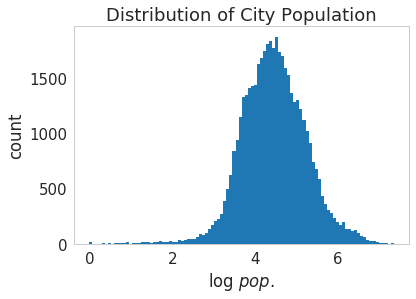

In [18]:
pd.Series(cities_gdf['population']).apply(np.log10).hist(bins=100)
plt.xlabel("log $pop.$")
plt.ylabel("count")
plt.title("Distribution of City Population")
plt.grid(False)

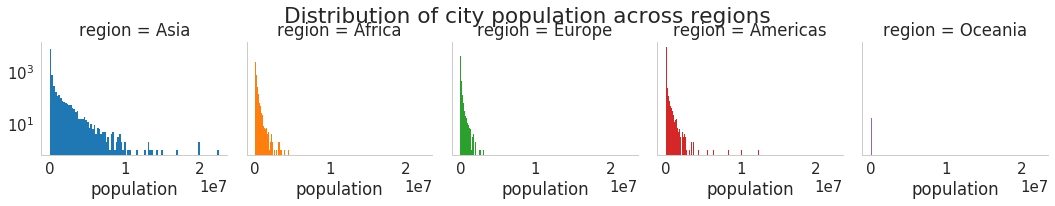

In [135]:
g = sns.FacetGrid(cities_gdf[cities_gdf['population']>10000], col="region", hue="region")
g = g.map(plt.hist, "population", log=True, bins=100)
g.fig.suptitle("Distribution of city population across regions\n\n")

# Extract example cities

#### Functions to process images for display

In [63]:
def basic_preprocess(img, res, log=False, scale=True):
    if img is None:
        return None
    img[img<0] = 0
    img = np.ceil(resize(img.squeeze(), (res,res), preserve_range=True))#.astype(int)
    if log:
        img = np.log(img + 1e-3)
    if scale:
        img = (img - img.min()) / (img.max() - img.min())
    return img

def overlay_mask(img, mask, ax, alpha=0.4):
    masked_data = np.ma.masked_where(mask, img)
    # Overlay the two images
    ax.imshow(img, cmap=cm.GnBu)
    ax.imshow(masked_data, cmap=cm.gray, interpolation='none', alpha=alpha)
    
def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)


#### Plot some examples

In [70]:
cities_gdf_sel[cities_gdf_sel.population>5e6].sample(10)

,index,city,province,country,countrycode,geometry,City,area,scale,location,region,subregion,population,size,Adj. population
72,72,rio de janeiro,rio de janeiro,brazil,bra,(POLYGON ((-43.5606956481933 -23.0784721374510...,"rio de janeiro, rio de janeiro, bra",1191.412663,72.290807,POINT (-43.44762799825764 -22.92335428531059),Americas,South America,6410575.0,very-large,7886994.0
35,35,theran,tehran,iran,irn,"POLYGON ((51.64118957519531 35.59123229980469,...","theran, tehran, irn",1405.846200,70.448035,POINT (51.4357574800909 35.74325693445566),Asia,Southern Asia,8359212.0,very-large,10548190.0
80,80,hugli,west bengal,india,ind,"POLYGON ((88.47233581542974 23.20706176757835,...","hugli, west bengal, ind",3152.109910,102.980178,POINT (88.07587628104955 22.88156947137584),Asia,Southern Asia,6054992.0,very-large,6054992.0
19,19,north 24 parganas,west bengal,india,ind,(POLYGON ((88.83472442626959 21.60722160339367...,"north 24 parganas, west bengal, ind",5810.193933,188.483221,POINT (88.77822373097831 22.46295129591472),Asia,Southern Asia,9583802.0,very-large,9583802.0
42,42,kinshasa,kinshasa city,democratic republic of the congo,cod,POLYGON ((15.95999908447277 -3.985559940338078...,"kinshasa, kinshasa city, cod",10978.220822,155.250281,POINT (15.9266886323858 -4.448898270855326),Africa,Middle Africa,7888929.0,very-large,7888929.0
86,86,nasirabad,dhaka,bangladesh,bgd,"POLYGON ((90.2787170410158 25.20021057128906, ...","nasirabad, dhaka, bgd",4282.320968,105.541659,POINT (90.431448323837 24.69640241691908),Asia,Southern Asia,5943914.0,very-large,5943914.0
44,44,fuyang,anhui,china,chn,"POLYGON ((115.6375427246094 33.56692504882824,...","fuyang, anhui, chn",10095.740430,164.641076,POINT (115.7004675527114 32.91640489401915),Asia,Eastern Asia,7717606.0,very-large,7717606.0
8,8,faisalabad,punjab,pakistan,pak,"POLYGON ((72.95734405517595 31.949422836304, 7...","faisalabad, punjab, pak",17800.372748,195.556220,POINT (72.62371843420178 31.20990508513964),Asia,Southern Asia,13232869.0,very-large,13232869.0
116,116,luan,anhui,china,chn,"POLYGON ((116.7591171264651 32.65515899658209,...","luan, anhui, chn",18393.246823,182.010981,POINT (116.3123625280914 31.757143036537),Asia,Eastern Asia,5128943.0,very-large,5128943.0
54,54,jining,shandong,china,chn,"POLYGON ((116.0040740966798 35.97055053710966,...","jining, shandong, chn",9531.398253,169.195301,POINT (116.6742631439264 35.3794964496485),Asia,Eastern Asia,7070902.0,very-large,7070902.0


paris 2483685.0
rio de janeiro 6410575.0
san francisco 930470.0
dhaka 14173108.0


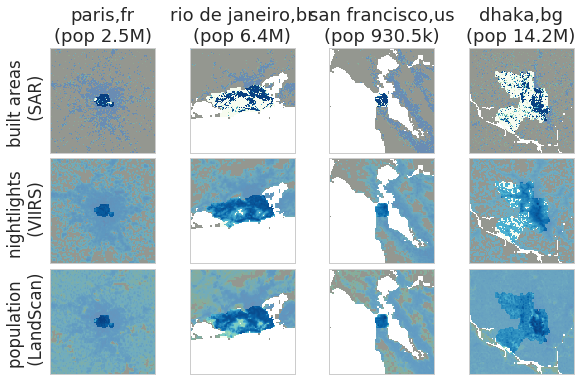

In [82]:
nimg = 4
nrow = 3

# smpl_df = cities_df_sel[cities_df_sel['Population']>2e6].sample(nimg).reset_index()

mycities = [("paris", "fra"), ("rio de janeiro", "bra"), 
            ("san francisco", "usa"), ("dhaka", "bgd")]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(10,6))
gs1 = gridspec.GridSpec(nrow, nimg)
gs1.update(wspace=0.0, hspace=0.05) # set the spacing between axes. 

for i, (cityname,countrycode) in enumerate(mycities):
    r = cities_gdf[(cities_gdf['city']==cityname) & (cities_gdf['countrycode']==countrycode)].iloc[0]
    lonlat, boundary = r['location'].centroid.xy, r['geometry']
    lon, lat = lonlat[0][0], lonlat[1][0]
    
    # extract population and compute total within city boundary
    imgPOP = popImgClient.extract_polygon_mask(boundary, w=100)
    imgPOP, bounds_mask = imgPOP[0], imgPOP[1]
    imgPOP[imgPOP<0] = 0
    city_pop = imgPOP[bounds_mask>0].sum()
    print cityname, city_pop
    imgPOP_disp = basic_preprocess(imgPOP, 128, log=True)
    bounds_mask = basic_preprocess(bounds_mask, 128)
    
    # built areas and nightlights
    imgSAR = sarImgClient.get_image_at_location((lat, lon), w=100)
    imgSAR_disp = basic_preprocess(imgSAR, 128)
    imgNLI = nliImgClient.get_image_at_location((lat, lon), w=100)
    imgNLI_disp = basic_preprocess(imgNLI, 128, log=True)
    
    # mark water areas with NaNs -- nothing can be built here
    imgWTR = wtrImgClient.get_image_at_location((lat, lon), w=100)
    water_mask = basic_preprocess(imgWTR, 128)

    imgPOP_disp[water_mask==0] = np.nan
    imgNLI_disp[water_mask==0] = np.nan
    imgSAR_disp[water_mask==0] = np.nan
    
    # plot built areas
    ax0 = plt.subplot(gs1[0,i]); ax0.set_xticks([]); ax0.set_yticks([])
    overlay_mask(imgSAR_disp, bounds_mask>0, ax0); ax0.set_ylabel("built areas \n (SAR)") if i==0 else None
    # plot Nightlights
    ax1 = plt.subplot(gs1[1,i]); ax1.set_xticks([]); ax1.set_yticks([])
    overlay_mask(imgNLI_disp, bounds_mask>0, ax1); ax1.set_ylabel("nightlights \n (VIIRS)") if i==0 else None
    # plot population
    ax2 = plt.subplot(gs1[2,i]); ax2.set_xticks([]); ax2.set_yticks([])
    overlay_mask(imgPOP_disp, bounds_mask>0, ax2); ax2.set_ylabel("population \n (LandScan)") if i==0 else None
    ax0.set_title("%s,%s\n(pop %s)"%(cityname,countrycode[:2], format_pop(city_pop)))
    

# Prune cities to spatially well-separated set

In [37]:
import geopy
from geopy import distance
from collections import OrderedDict
from sklearn.neighbors import KDTree, BallTree

from pysatml.utils.gis_utils import compute_geo_distance_km

point2loc = lambda p: tuple(np.array(p.centroid.coords.xy).squeeze())
    
cities_gdf_10k = cities_gdf[cities_gdf['population']>=1e5].copy()
cities_gdf_10k.sort_values("population", ascending=False, inplace=True)
cities_gdf_10k = cities_gdf_10k.reset_index().drop("index", 1)
cityloc_latlon = np.array(map(lambda x: (x.centroid.xy[1][0], x.centroid.xy[0][0]), 
    cities_gdf_10k['location'].values))
spatial_index = BallTree(cityloc_latlon, leaf_size=10, \
                         metric=compute_geo_distance_km)

# construct ordered dictionary of cities
cities_list = cities_gdf_10k.to_dict("records")
cities_list.sort(key=lambda x: x['population'])
cities_list = cities_list[::-1]
cities_dict = OrderedDict(zip([x['City'] for x in cities_list], cities_list))

In [38]:
n_neighbors = 20   # number of nearest neighbors to query
d_threshold = 25   # radius in KM

to_remove = set()
already_visited = set()
new_pop = {}

i = 0
while i < len(cities_dict):
    c0 = cities_dict.keys()[i]
    if c0 in to_remove:
        i += 1
        continue
    already_visited = already_visited.union(set([c0]))
    print i, '/', len(cities_dict), ":", c0
    clear_output(wait=True)
    r0 = cities_dict[c0]
    p = r0['geometry']
    loc0 = point2loc(p)[::-1]
    neighbors = spatial_index.query(loc0, k=n_neighbors)[1][0][1:]
    new_pop[c0] = r0['population']
    for j,n in enumerate(neighbors):
        r = cities_gdf_10k.iloc[n]
        c = r['City']
        loc = point2loc(r['location'])[::-1]
        d = compute_geo_distance_km(loc0, loc)
        if d > 0 and d <= d_threshold and c not in already_visited:
            to_remove = to_remove.union(set([c]))
            new_pop[c0] += r['population']
    i += 1
    
cities_gdf_sel = cities_gdf_10k[~cities_gdf_10k['City'].isin(to_remove)]
cities_gdf_sel['Adj. population'] = map(lambda c,p: new_pop[c] if c in new_pop else p,
                                  cities_gdf_sel['City'], cities_gdf_sel['population'])
cities_gdf_sel.reset_index(inplace=True)

print "Cities over 100k pop: %d; Pruned list: %d cities. "%(len(cities_gdf_10k), len(cities_gdf_sel))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Cities over 100k pop: 10591; Pruned list: 7653 cities. 


In [39]:
cities_gdf_sel.to_csv(outPath + "/selected_urban_areas_100k.csv", index=False)
cities_gdf_sel.drop('location',1).to_file(driver = 'ESRI Shapefile', filename=outPath + "selected_urban_areas_100k.shp")

# cities_df_sel = gpd.GeoDataFrame(pd.read_csv(outPath + "/selected_urban_areas.csv"))
# cities_df_sel['geometry'] = cities_df_sel['geometry'].apply(lambda x: loads(x))

(array([-100.,  -50.,    0.,   50.,  100.]),
 <a list of 5 Text yticklabel objects>)

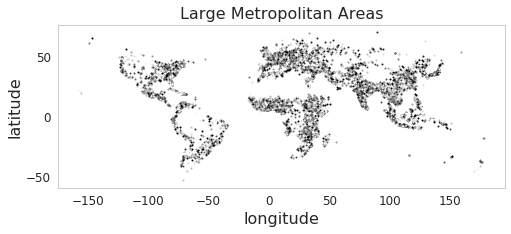

In [83]:
city_locations_sel = gpd.GeoSeries(cities_gdf_sel['location'])
city_locations_sel.plot(figsize=(8,6), cmap='Greys')
plt.title("Large Metropolitan Areas", fontsize=16)
plt.ylabel("latitude", fontsize=16)
plt.xlabel("longitude", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

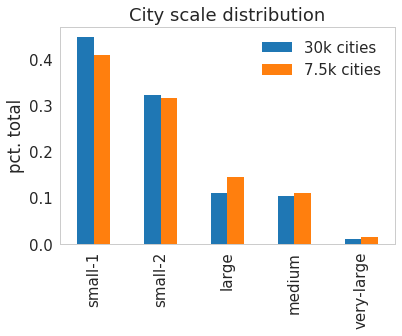

In [41]:
dist_25 = cities_gdf_10k['size'].value_counts() / float(len(cities_gdf_10k))
dist_03 = cities_gdf_sel['size'].value_counts() / float(len(cities_gdf_sel))
scale_df = pd.concat([dist_25, dist_03], axis=1)
scale_df.columns = ["30k cities", "7.5k cities"]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
scale_df.plot(kind="bar")
plt.title("City scale distribution")
plt.ylabel("pct. total")

# Extract  samples: 
* training: all cities > 10k population
* test: filtered cities (by population & location)

In [42]:
kmScale = 100 # window of 100km width around center
res = 128
take_log = False

# training samples
df = cities_gdf[cities_gdf.population>10000]

phase = 'log' if take_log else "raw"

cur_dir = outPath + "spatial-maps/%s"%(phase)
if not os.path.exists(cur_dir):
    os.makedirs(cur_dir)

from skimage.io import imsave

for i,(idx,r) in enumerate(df.iloc[:80].iterrows()):
    clear_output(wait=True)
    print "city %d/%d" % (i, len(df))

    lonlat, boundary = r['location'], r['geometry']
    imgLat, imgLon = point2loc(lonlat)[::-1]
    city, country = r['city'].replace(" ","-"), r['country'].replace(" ","-")
    popNum, popClass = int(r['population']), r['size'].replace(" ","-")

    # extract population and compute total within city boundary
    try:
        imgPOP = popImgClient.extract_polygon_mask(boundary, w=kmScale)
    except:
        imgPOP = popImgClient.extract_polygon_mask(boundary.buffer(2).buffer(-2), w=kmScale)
    imgPOP, bounds_mask = imgPOP[0], imgPOP[1]
    imgPOP = basic_preprocess(imgPOP, res, log=take_log, scale=False)
    bounds_mask = basic_preprocess(bounds_mask, res)

    imgSAR = sarImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgSAR = basic_preprocess(imgSAR, res)
    imgNLI = nliImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgNLI = basic_preprocess(imgNLI, res, log=take_log, scale=False)
    imgWTR = wtrImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgWTR = basic_preprocess(imgWTR, res, scale=take_log)
    if imgSAR is None or imgNLI is None or imgPOP is None or imgWTR is None:
        continue
                       
    # save images to files
    filename = "%s/SAR_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgSAR)
    filename = "%s/NLI_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgNLI)
    filename = "%s/POP_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgPOP)
    filename = "%s/WTR_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgWTR)
    filename = "%s/BND_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, bounds_mask)


city 79/32988
